In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle

In [3]:
from pegasos_experiment import generate_qsvm_data
from feature_maps import MediumFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import Aer
from pegasos import pegasos
from sklearn.metrics import hinge_loss

In [4]:
# blue
color_0 = '#1f77b4'
color_0_light = '#8fbbd9'

# orange
color_1 = '#ff7f0e'
color_1_light = '#ffbf86'

colors = [color_0, color_1]
colors_light = [color_0_light,color_1_light]

# other constants
lower_percentile = 0.159
upper_percentile = 0.841

plt.rcParams.update({'font.size': 24,
                     'xtick.labelsize': 20,
                     'ytick.labelsize': 20,
                     'axes.titlesize': 28,
                     'axes.labelsize': 28,
                     'mathtext.fontset': 'stix',
                     'font.family': 'STIXGeneral'})

In [5]:
margin = 0.1
Ms = 2**np.arange(2,12)
N = 1000
C = 1000
tol = 1e-4

In [10]:
# Feature map for the experiment
feature_map = MediumFeatureMap(2,4)

# Kernel
adhoc_backend = QuantumInstance(Aer.get_backend('statevector_simulator'))
adhoc_kernel = QuantumKernel(feature_map=feature_map.get_reduced_params_circuit(), quantum_instance=adhoc_backend)

np.random.seed(41)
seeds = np.random.randint(0,10000,10)
dtypes = {'seed': int, 'C' : int, 'M' : int}
# Checking whether experiment has already been partially done and loading existing data
try:
    results = pd.read_csv(f'data/M_{margin}_data.csv',dtype=dtypes)
except:
    columns = ['seed','C','M']
    results = pd.DataFrame(columns=columns)
    results.to_csv(f'data/M_{margin}_data.csv',index=False)

for M in tqdm(Ms):
    if ((results['M'] == M) & (results['C'] == C)).any():
        print(f'Found M {M}')
        #continue
    # Creating artificial data
    (X,y), (Xt,yt) = generate_qsvm_data(feature_map,0.1,M,0)
    K = adhoc_kernel.evaluate(X)
    for s in seeds:
        y_preds, _,_,_ = pegasos(K,y,N,C,seed=s,full_returns=True)
        losses = [hinge_loss(y,yp) for yp in y_preds]
        pickle.dump(losses,open(f'data/dumps/M_dependence_{s}_C_{C}_M_{M}.pkl','wb'))
        results.loc[results.shape[0]] = [s,C,M]
        results.to_csv(f'data/M_{margin}_data.csv',index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Found M 4


 10%|█         | 1/10 [00:04<00:37,  4.21s/it]

Found M 8


 20%|██        | 2/10 [00:08<00:33,  4.23s/it]

Found M 16


 30%|███       | 3/10 [00:13<00:30,  4.38s/it]

Found M 32


 40%|████      | 4/10 [00:18<00:28,  4.75s/it]

Found M 64


 50%|█████     | 5/10 [00:25<00:27,  5.50s/it]

Found M 128


 60%|██████    | 6/10 [00:35<00:28,  7.12s/it]

Found M 256


 70%|███████   | 7/10 [00:50<00:29,  9.71s/it]

Found M 512


 80%|████████  | 8/10 [01:17<00:30, 15.27s/it]

Found M 1024


 90%|█████████ | 9/10 [02:20<00:30, 30.14s/it]

Found M 2048


100%|██████████| 10/10 [05:19<00:00, 31.94s/it]


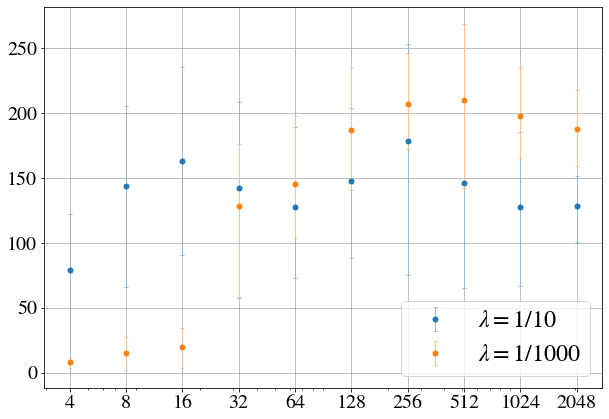

In [11]:
plt.figure(figsize=(10,7))
for k, C in enumerate([10,1000]):
    convergence_after = np.zeros((len(Ms),len(seeds)))
    for i, M in enumerate(Ms):
        for j, s in enumerate(seeds):
            filename = f'data/dumps/M_dependence_{s}_C_{C}_M_{M}.pkl'
            hinges = np.array(pickle.load(open(filename,'rb')))
            diff = np.abs(hinges[1:] - hinges[:-1])
            convergence_after[i,j] = np.where(diff < tol)[0][0]

    means = np.mean(convergence_after,axis=1)
    upper = np.quantile(convergence_after, upper_percentile, axis=1)
    lower = np.quantile(convergence_after,lower_percentile,axis=1)
    errors = np.array([means - lower, upper - means])
    
    plt.errorbar(Ms,means,yerr=errors,label=r'$\lambda = 1/{{%s}}$'%int(C),marker='.',ecolor=colors_light[k],elinewidth=1.,ls='',capsize=2,
            color=colors[k], ms=10)

plt.xscale('log')
plt.xticks(Ms,Ms)
plt.grid()
plt.legend()
plt.savefig('plots/pegasos_M_independent.png',dpi=300,bbox_inches='tight')

In [13]:
convergence_after

array([[  4.,   9.,  10.,  10.,   9.,  12.,   2.,   9.,   3.,  14.],
       [ 11.,  29.,   1.,  26.,  17.,  18.,   1.,   3.,  38.,   8.],
       [  6.,   9.,  41.,   2.,  26.,  17.,  18.,  67.,   1.,   9.],
       [ 64., 178.,  79., 174., 258., 156.,  54.,  41., 129., 148.],
       [126., 104., 181., 104., 243.,  91., 141., 114., 142., 210.],
       [190.,  72., 212., 215., 128., 173., 158., 247., 218., 253.],
       [145., 221., 265., 306., 220., 179., 174., 204., 171., 183.],
       [273., 146., 219., 215., 192., 139., 262., 234., 289., 129.],
       [183., 201., 247., 262., 221., 176., 209., 157., 138., 180.],
       [167., 204., 153., 222., 246., 140., 193., 170., 169., 213.]])

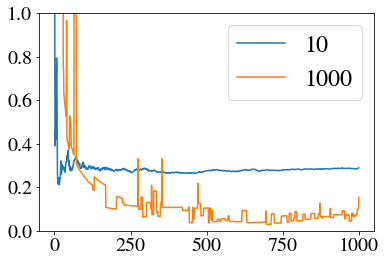

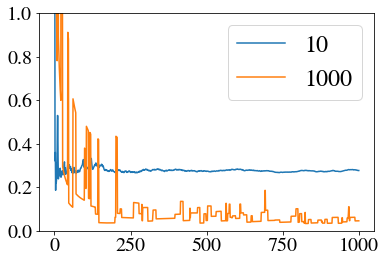

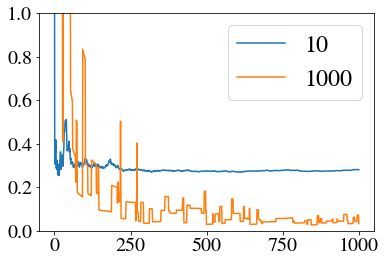

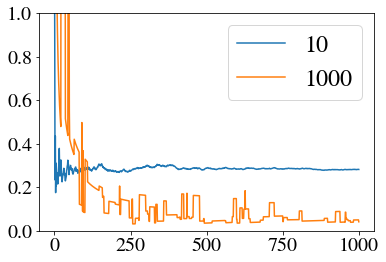

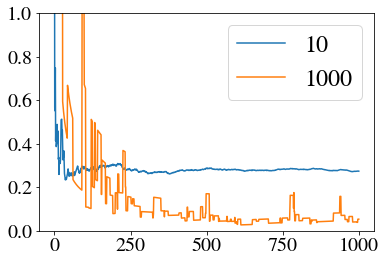

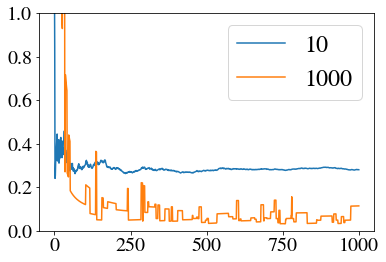

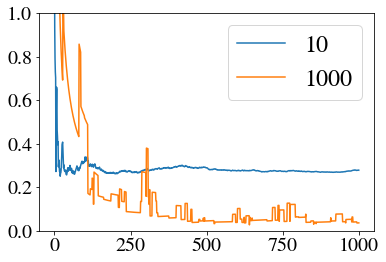

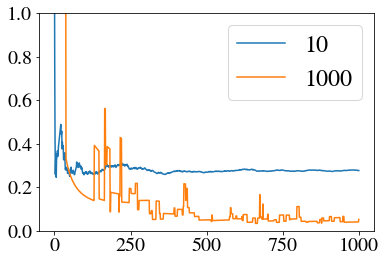

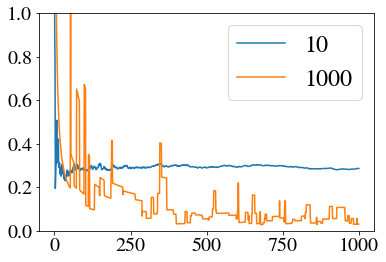

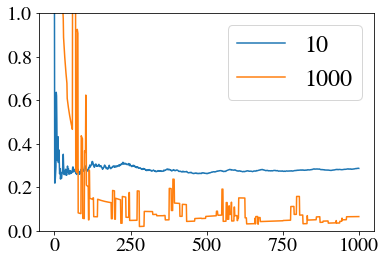

In [12]:
for j, s in enumerate(seeds):
    for i, M in enumerate(Ms):
        if M != 512:
            continue
        plt.figure()
        for k, C in enumerate([10,1000]):
            filename = f'data/dumps/M_dependence_{s}_C_{C}_M_{M}.pkl'
            hinges = np.array(pickle.load(open(filename,'rb')))
            plt.plot(hinges,label=C)
        plt.legend()
        plt.ylim(0,1)
    


In [67]:
ytrue = np.array([1,-1,1,1])
ytest = np.array([5,0.3,12,0.4])*1000
hinge_loss(ytrue,ytest)


75.25